# LIM Analysis of the Northern Annular Mode (NAM)

## Import modules

In [11]:
import math
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import os

import calendar
import datetime as dt

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline
mpl.rc('image', cmap='bwr')

from get_AM_mod import ERA5, NAM, get_y
from tools_AM_mod import cov_lag, find_event
from LIM_AM_mod import LIM, rand_model, Myla
from stats_mod import stats_tests_normal, stats_tests_rand_model, bootstrap, bootstrap_model, StackArray

from numpy import linalg as la

plev = [850.,  700.,  500.,  250.,  100.,   50.,   10.]
len_slice = 150
offset = 40

## Load data
* y: original data
* y2: original data + padding of length `offset` before and after for composite analysis
* y3: data generated by random model

In [12]:
data = ERA5(name_dir='ERA5', year_start=1950, year_end=2021, plev=plev, source_dir='cmip6')

data_z37 = ERA5(name_dir='ERA5', year_start=1950, year_end=2021, source_dir='cmip6')

D, p, y, t, y2 = get_y(data, 'NAM')
D_z37, p_z37, y_z37, t_z37, y2_z37 = get_y(data_z37, 'NAM')


Calculating from the original data .......
ERA5 (72, 365, 7) 	calendar: 365_day
t.shape = (150,), y.shape = (71, 150, 7), y2.shape = (71, 230, 7)
Calculating from the original data .......
ERA5 (72, 365, 37) 	calendar: 365_day
t.shape = (150,), y.shape = (71, 150, 37), y2.shape = (71, 230, 37)


## EOFs

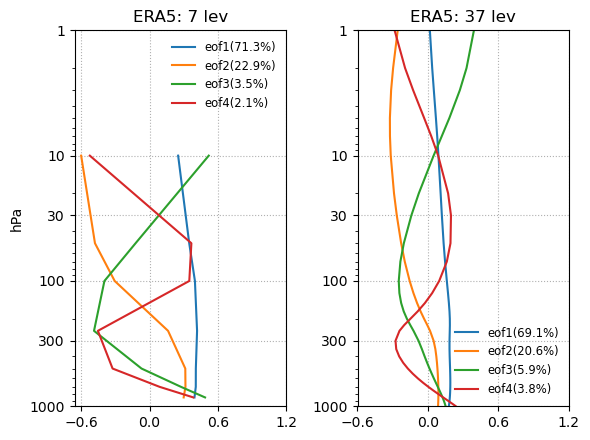

In [13]:
U, s, _ = Myla.svd(y)
s_prct = (s*s)[:4]/np.sum(s*s)*100

U_z37, s_z37, _ = Myla.svd(y_z37)
s_prct_z37 = (s_z37*s_z37)[:4]/np.sum(s_z37*s_z37)*100

fig = plt.figure(figsize=(6,4.5))
fig.add_subplot(1,2,1)
for eofi in range(4):
    plt.plot(U[:, eofi]/np.sign(U[-1, eofi]), p, '-', label=f'eof{eofi+1}({s_prct[eofi]:.1f}%)')
plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([1, 10, 30, 100, 300, 1000])
plt.ylabel('hPa')
plt.xticks([-0.6, 0, 0.6, 1.2])
plt.legend(fontsize='small', loc='upper right', frameon=False)
plt.title('ERA5: 7 lev')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.grid(True, linestyle=':')

fig.add_subplot(1,2,2)
for eofi in range(4):
    plt.plot(U_z37[:, eofi]/np.sign(U_z37[-1, eofi]), p_z37, '-', label=f'eof{eofi+1}({s_prct_z37[eofi]:.1f}%)')
plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.yscale('log')
plt.yticks([1, 10, 30, 100, 300, 1000])
# plt.ylabel('hPa')
plt.xticks([-0.6, 0, 0.6, 1.2])
plt.legend(fontsize='small', loc='lower right', frameon=False)
plt.title('ERA5: 37 lev')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
plt.grid(True, linestyle=':')

plt.tight_layout()
# plt.savefig(f'Figs/LIM_eofs.pdf', transparent=True)


## Computing LIM for both 7-level and 37-level data

In [14]:
hyp_param = dict(lim = dict(lag_time = 5,
                            r_optimal = 4,    # use 4 SVDs
                            eig_method = 'pinv',
                            ord   = 2,
                            )
                )
print(f'hyperpamameters:\n{hyp_param}')

#=========================================
model = LIM(y, hyp_param, verbose=True)
#-----
y3 = rand_model(model.B_r, model.vr_Q, model.w_Q, len_day=len_slice*1000, dt=0.2, verbose=False, get_x_from_r=model.get_x_from_r)

# decomposition by modes
y2_mode = model.mode(y2)
y3_mode = model.mode(y3)
# Define the strat-trop coupling mode
y2_strat = y2_mode[:,:,:,:2].sum(axis=3)
y3_strat = y3_mode[:,:,:2].sum(axis=2)

#=========================================
model_z37 = LIM(y_z37, hyp_param, verbose=True)
#-----
y3_z37 = rand_model(model_z37.B_r, model_z37.vr_Q, model_z37.w_Q, len_day=len_slice*1000, dt=0.2, verbose=False, get_x_from_r=model_z37.get_x_from_r)

# decomposition by modes
y2_z37_mode = model_z37.mode(y2_z37)
y3_z37_mode = model_z37.mode(y3_z37)
# Define the strat-trop coupling mode
y2_z37_strat = y2_z37_mode[:,:,:,:2].sum(axis=3)
y3_z37_strat = y3_z37_mode[:,:,:2].sum(axis=2)


hyperpamameters:
{'lim': {'lag_time': 5, 'r_optimal': 4, 'eig_method': 'pinv', 'ord': 2}}
POP e-folding timescales =29.4894, 29.4894, 8.1434, 4.3159
r_opt=4: % of var=99.804024, norm=2.009589, err=0.476010, R2=0.523990, s=1.072598
POP e-folding timescales =32.5929, 32.5929, 8.3522, 4.6224
r_opt=4: % of var=99.350983, norm=1.987785, err=0.518116, R2=0.481884, s=0.934889


## Eigenvalues and eigenvectors

In [15]:
# bootstrap of eigenvalues and eigenvectors
print(f'hyperpamameters:\n{hyp_param}')
Stack_LIM = StackArray()

def stat_func(y, axis):
    model = LIM(y, hyp_param, verbose=False)
    Stack_LIM.add_array('b_r', model.b.real)
    Stack_LIM.add_array('b_i', model.b.imag)
    sn = np.sign(model.vr[p==500, 0].real)*la.norm(model.vr[:, 0])/np.sqrt(len(model.vr))
    Stack_LIM.add_array('vr_r', model.vr.real/sn)
    Stack_LIM.add_array('vr_i', model.vr.imag/sn)
    return Stack_LIM.stack()

ci_stacked, dis_stacked, se_stacked = bootstrap(y, statistic=stat_func, n_resamples=1000, confidence_level=0.95, random_state=42, method='percentile')

ci = (Stack_LIM.unstack(ci_stacked[0], 'low'), Stack_LIM.unstack(ci_stacked[1], 'high'))

hyperpamameters:
{'lim': {'lag_time': 5, 'r_optimal': 4, 'eig_method': 'pinv', 'ord': 2}}


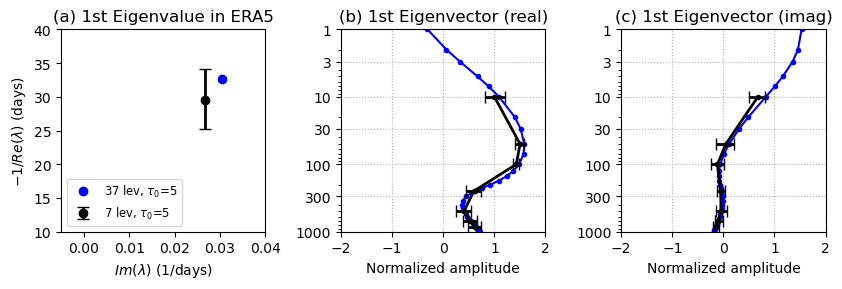

In [16]:
fig = plt.figure(figsize=(8.5,3))
sym = ['o', '^', 'd', 's', 'p', 'h']

fig.add_subplot(1,3,1)
markersize = 6
for mm in range(1): # range(len(model.b)):
    yerr = [[-1/model.b[mm].real + 1/ci[0].b_r[mm]], [-1/ci[1].b_r[mm] + 1/model.b[mm].real]]
    # xerr = [[model.b[mm].imag - ci[0].b_i[mm]], [ci[1].b_i[mm] - model.b[mm].imag]]
    plt.errorbar(model.b[mm].imag, -1/model.b[mm].real, yerr, fmt=sym[mm]+'k', linewidth=2, capsize=4, label=r'7 lev, $\tau_0$=5')

    plt.plot(model_z37.b[mm].imag, -1/model_z37.b[mm].real,  sym[mm]+'b',  ms=markersize, label=r'37 lev, $\tau_0$=5')
    if mm == 0:
        plt.legend(fontsize='small', loc='lower left')

plt.xlim((-0.005, 0.04))
plt.xticks([0, 0.01, 0.02, 0.03, 0.04])
plt.ylim((10, 40))
plt.xlabel(r'$Im(\lambda)$ (1/days)')
plt.ylabel(r'$-1/Re(\lambda)$ (days)')
plt.title('(a) 1st Eigenvalue in ERA5')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

fig.add_subplot(1,3,2)
def get_sn(model, p):
    return np.sign(model.vr[p==500, 0].real)*la.norm(model.vr[:, 0])/np.sqrt(len(model.vr))
sn = get_sn(model,p)
sn_z37 = get_sn(model_z37, p_z37)

eig0 = model.vr[:, 0].real/sn
xerr = [eig0-ci[0].vr_r[:,0], ci[1].vr_r[:,0]-eig0]
plt.errorbar(eig0, p, xerr=xerr, fmt='-k.', linewidth=2, capsize=4, zorder=4, label=r'7 lev, $\tau_0$=5')
# plt.fill_betweenx(p, ci[0].vr_r[:, 0], ci[1].vr_r[:, 0], color='green',zorder=5, alpha=0.3)
plt.plot(model_z37.vr[:, 0].real/sn_z37, p_z37,  '-b.', label=r'37 lev, $\tau_0$=5')

plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-2, 2))
plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([1, 3, 10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('(b) 1st Eigenvector (real)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

fig.add_subplot(1,3,3)
eig0 = model.vr[:, 0].imag/sn
xerr = [eig0-ci[0].vr_i[:,0], ci[1].vr_i[:,0]-eig0]
plt.errorbar(eig0, p, xerr=xerr, fmt='-k.', linewidth=2, capsize=4, zorder=4, label=r'7 lev, $\tau_0$=5')
# plt.fill_betweenx(p, ci[0].vr_i[:, 0], ci[1].vr_i[:, 0], color='green', zorder=5, alpha=0.3)
plt.plot(model_z37.vr[:, 0].imag/sn_z37, p_z37,  '-b.', label=r'37 lev, $\tau_0$=5')

plt.ylim((1, 1000))
plt.gca().invert_yaxis()
plt.xlabel('Normalized amplitude')
# plt.ylabel('Pressure (hPa)')
plt.xlim((-2, 2))
plt.xticks([-2, -1, 0, 1, 2])
plt.yscale('log')
plt.yticks([1, 3, 10, 30, 100, 300, 1000])
plt.grid(linestyle=':')
plt.title('(c) 1st Eigenvector (imag)')
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
# plt.legend()

plt.tight_layout()
# plt.savefig('Figs/LIM_eigs.pdf', transparent=True)

## Weak vortex events - 7-level LIM

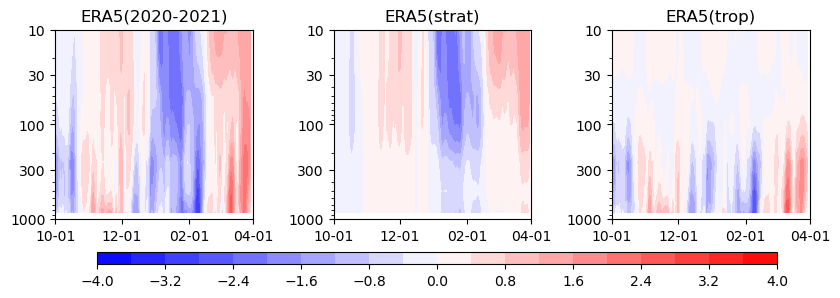

In [17]:
def plot_snapshot(name, p, y2):
    plt.contourf(time, p, y2.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.xlim([time[9], time[-1]])
    plt.xticks(mdates.date2num([dt.date(year, 10, 1), dt.date(year, 12, 1), 
                                dt.date(year+1, 2, 1), dt.date(year+1, 4, 1)]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name)

y2_trop = y2 - y2_strat

year = 2020
d_start = mdates.date2num(dt.date(year, 9, 22))
if calendar.isleap(year+1):
    d_end = mdates.date2num(dt.date(year+1, 3, 29))
else:
    d_end = mdates.date2num(dt.date(year+1, 3, 30))
time = np.linspace(d_start, d_end, round(d_end-d_start+1))
yi = year - D.data.year_start

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(8.5, 3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 4, 11
ax1 = fig.add_subplot(1, 3, 1)
plot_snapshot(f"ERA5({year}-{year+1})", p, y2[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 2)
plot_snapshot(f"ERA5(strat)", p, y2_strat[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 3)
y2_trop = y2 - y2_strat
plot_snapshot(f"ERA5(trop)", p, y2_trop[yi, :offset+len_slice, :])

plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_ERA5_snapshot.pdf', transparent=True)

## Weak vortex events - 37-level LIM

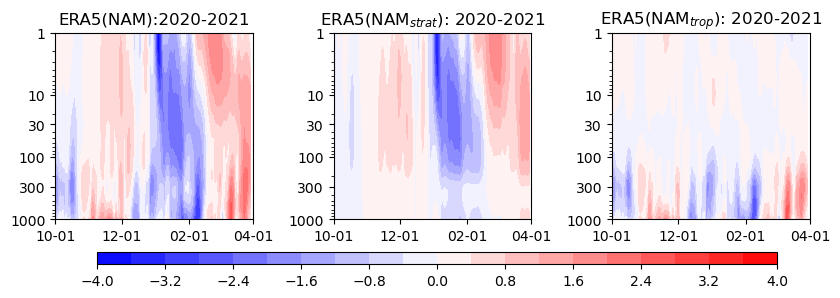

In [18]:
def plot_snapshot(name, p, y2):
    plt.contourf(time, p, y2.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([1, 10, 30, 100, 300, 1000])
    plt.xlim([time[9], time[-1]])
    plt.xticks(mdates.date2num([dt.date(year, 10, 1), dt.date(year, 12, 1), 
                                dt.date(year+1, 2, 1), dt.date(year+1, 4, 1)]))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    plt.gca().yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name)

y2_z37_trop = y2_z37 - y2_z37_strat

year = 2020
d_start = mdates.date2num(dt.date(year, 9, 22))
if calendar.isleap(year+1):
    d_end = mdates.date2num(dt.date(year+1, 3, 29))
else:
    d_end = mdates.date2num(dt.date(year+1, 3, 30))
time = np.linspace(d_start, d_end, round(d_end-d_start+1))
yi = year - D.data.year_start

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(8.5, 3))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 4, 11
ax1 = fig.add_subplot(1, 3, 1)
plot_snapshot(f"ERA5(NAM):{year}-{year+1}", p_z37, y2_z37[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 2)
plot_snapshot(r"ERA5(NAM$_{strat}$): " + f"{year}-{year+1}", p_z37, y2_z37_strat[yi, :offset+len_slice, :])

ax1 = fig.add_subplot(1, 3, 3)
y2_z37_trop = y2_z37 - y2_z37_strat
plot_snapshot(r"ERA5(NAM$_{trop}$): " + f"{year}-{year+1}", p_z37, y2_z37_trop[yi, :offset+len_slice, :])

plt.tight_layout()
fig.subplots_adjust(bottom=0.25)
cax = fig.add_axes([0.12, 0.1, 0.80, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))

# plt.savefig('Figs/AM_event_ERA5_snapshot_z37.pdf', transparent=True)

## Composite of Weak Vortex Events

In [19]:
lag_time = 40
threshold = -2
# threshold = 1.5
lags = np.arange(lag_time+1)
lags2= range(-lag_time, lag_time+1)

y2_event, y2_num = find_event(y, p, y2=y2, threshold=threshold, lag_time=lag_time)
y2_strat_event, y2_num = find_event(y, p, y2=y2_strat, threshold=threshold, lag_time=lag_time)

y3_event, y3_num = find_event(y3[None, lag_time:-lag_time], p, y2=y3[None,:], threshold=threshold, lag_time=lag_time)
y3_strat_event, y3_num = find_event(y3[None, lag_time:-lag_time], p, y2=y3_strat[None,:], threshold=threshold, lag_time=lag_time)

# of events: 38(0.54)
# of events: 38(0.54)
# of events: 396(396.00)
# of events: 396(396.00)


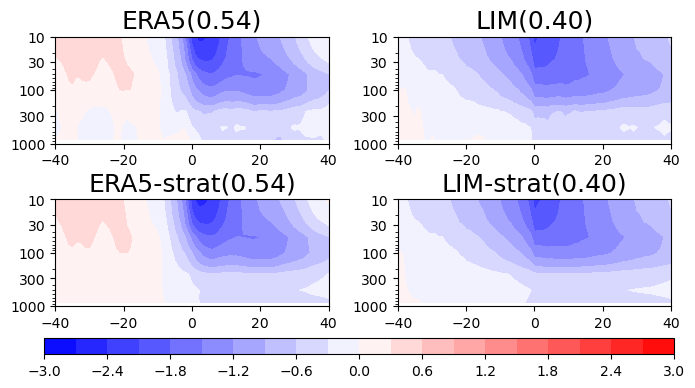

In [20]:
def plot_event(name, p, y0_event):
    plt.contourf(lags2, p, y0_event.T, np.linspace(-cmax, cmax, cnum*2-1), cmap=cm)
    # plt.plot(np.zeros_like(p), p, '-k')
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    # plt.ylabel('hPa')
    plt.xticks([-40, -20, 0, 20, 40])
    # plt.xlabel('Lag (days)')
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.title(name, fontsize=18)

cm = 'bwr' # 'RdBu_r' # 'seismic' # 
fig = plt.figure(figsize=(7,4))
mpl.rcParams.update({'font.size': 10})

cmax, cnum = 3, 11
ax1 = fig.add_subplot(2, 2, 1)
plot_event(f"ERA5({y2_num/(2021-1950):.2f})", p, y2_event)

ax1 = fig.add_subplot(2, 2, 2)
plot_event(f"LIM({y3_num/1000:.2f})", p, y3_event)

ax1 = fig.add_subplot(2, 2, 3)
plot_event(f"ERA5-strat({y2_num/(2021-1950):.2f})", p, y2_strat_event)

ax1 = fig.add_subplot(2, 2, 4)
plot_event(f"LIM-strat({y3_num/1000:.2f})", p, y3_strat_event)

plt.tight_layout()
fig.subplots_adjust(bottom=0.22)
cax = fig.add_axes([0.07, 0.1, 0.90, 0.04])    #[left, bottom, width, height]
cbar = plt.colorbar(cax=cax, orientation='horizontal')
cbar.set_ticks(np.linspace(-cmax, cmax, cnum))
# mpl.rcParams.update({'font.size': 18})

# plt.savefig('Figs/AM_event_ERA5_LIM.pdf', transparent=True)